# Описание проекта

Вам предстоит научитсья моделировать отток клиентов телеком компании. Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. 

## Описание файлов

- `train.csv` - файл с обучающей выборкой.- `test.csv` - файл с тестовой выборкой.- - `submission.csv` - пример посылки.

## Описание услуг

    Оператор предоставляет два основных типа услуг: - 1. 
Стационарную телефонную связь. Телефон можно подключить к нескольким линиям одновременно.
- 2. 
Интернет. Подключение может быть двух типов: через телефонную линию `(DS`L, от англ.` digital subscriber lin`e — «цифровая абонентская линия») или оптоволоконный кабель `(Fiber optice`s.

Также доступны такие услуги:
- Интернет-безопасность: антивирус (`HasDeviceProtection`) и блокировка небезопасных сайтов (`HasOnlineSecurityService`);
- Выделенная линия технической поддержки (`HasTechSupportAccess`);
- Облачное хранилище файлов для резервного копирования данных (`HasOnlineBackup`);
- Стриминговое телевидение (`HasOnlineTV`) и каталог фильмов (`HasMovieSubscription`).

Данные состоят: 
- `ClientPeriod` - время использования услугами;
- `MonthlySpending` - расходы за месяц
- `TotalSpent` - общие расходы абонента;
- `Sex` - пол;
- `IsSeniorCitizen` - является ли абонент пенсионером;
- `HasPartner` - есть ли у абонента супруг или супруга;
- `HasChild` - есть ли у абонента дети;
- `HasPhoneService` - подключение телефонной связи;
- `HasMultiplePhoneNumbers` -  подключение телефона к нескольким линиям одновременно;
- `HasInternetService` - тип подключения;
- `HasOnlineSecurityService` - блокировка опасных сайтов;
- `HasOnlineBackup` - облачное хранилище файлов для резервного копирования данных;
- `HasDeviceProtection` - антивирус;
- `HasTechSupportAccess` - выделенная линия технической поддержки;
- `HasOnlineTV` -  стриминговое телевидение;
- `HasMovieSubscription` - каталог фильмов;
- `HasContractPhone` - имеет контактный телефон;
- `IsBillingPaperless` - электронный расчётный лист;
- `PaymentMethod` - тип платежа;
- `Churn` - отток абонентов.

## Импорт библиотек

In [7]:
# импорт библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import phik
from phik import  phik_matrix
import time
import shap

from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import (
    OneHotEncoder, 
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler, 
    RobustScaler
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier

## Функции и константы

In [9]:
# константы 
RANDOM_STATE = 80724
# отключеие предупреждений
warnings.filterwarnings('ignore')

In [10]:
# функция №1 для изучения датафрейма
def data_info(data):
    print(f"размер датасета {data.shape}")
    print('_'*50)
    display(data.head(5))
    print('_'*50)
    data.info()
    print('_'*50)
    display(data.describe())

In [11]:
# функция №2 для удаления дубликатов (с учетам таргета)
def duplicat(data):
    print(f"Размер DataFrame с дубликатами: {data.shape}")
    # удаляем целевой признак
    X_data = data.drop('Churn', axis=1)
    # Получаем индексы (номера строк) дубликатов
    duplicate_indices = X_data[X_data.duplicated()].index
    # Выводим количество строк дубликатов
    print(f'Количество строк дубликатов: {X_data.duplicated().sum()}')
    # Получаем DataFrame без дубликатов
    # Удаление строк по индексам
    deduped_data = data.drop(index=duplicate_indices)
    print(f"Размер DataFrame без дубликатов: {deduped_data.shape}")
    return deduped_data

In [12]:
# функция №3 для поиска неявных дубликатов
def hidden_duplicat(data):
    for column in data.columns:
        if data[column].dtype == 'object':
            unique_values = data[column].unique()
            print(f"Уникальные значения для столбца '{column}': {unique_values}")

In [13]:
# функция №4 для изучения распределения непрерывных признаков
def make_hist_box(df, features):
    for feature in features:
        f, (ax_box, ax_hist) = plt.subplots(2, sharex=True,
                                            gridspec_kw={'height_ratios': (.15, .85)})
        sns.boxplot(df[feature], orient='h', ax=ax_box)
        sns.histplot(data=df, x=feature, ax=ax_hist)
        ax_box.set(xlabel='')
        ax_box.set_title(f'Boxplot of {feature}')
        ax_hist.set_title(f'Histogram of {feature}')
        
        # Добавление вертикальной линии для среднего значения
        mean_value = df[feature].mean()
        ax_hist.axvline(x=mean_value, color='r', linestyle='--', label='Mean')

        # Добавление вертикальной линии для медианы
        median_value = df[feature].median()
        ax_hist.axvline(x=median_value, color='g', linestyle='-', label='Median')

        # Добавление легенды
        ax_hist.legend()

        plt.show()

In [14]:
# функция №5 для изучения распределения дискретных признаков
def make_countplot(df, features):
    for feature in features:
        fig, ax = plt.subplots(figsize=(8, 4))
        sns.countplot(data=df, x=feature, ax=ax)
        ax.set_title(f'Countplot of {feature}')
        plt.show()

In [15]:
# функция №6 для загрузки данных
def load_data(file_path_local, file_path_remote):
    if os.path.exists(file_path_local):
        df = pd.read_csv(file_path_local)
    elif os.path.exists(file_path_remote):
        df = pd.read_csv(file_path_remote)
    else:
        raise FileNotFoundError(f"Файл не найден ни по пути '{file_path_local}', ни по пути '{file_path_remote}'.")
    return df

In [16]:
# функция №7 для построения графиков с раделением на группы
def proba_plot(data, column):
    array0 = []
    array1 = []
    unique_list = list(data[column].unique())
    for i in range(len(unique_list)):
        all_unique = data.loc[data[column] == unique_list[i], column].count()

        target_1 = data.loc[(data[column] == unique_list[i]) & (data['Churn'] == 1), column].count()
        proba1 = np.round((target_1 / all_unique), 2)
        target_0 = data.loc[(data[column] == unique_list[i]) & (data['Churn'] == 0), column].count()
        proba0 = np.round((target_0 / all_unique), 2)

        array0.append([unique_list[i], proba0, '0'])
        array1.append([unique_list[i], proba1, '1'])

    array = np.concatenate([array0, array1], axis=0)
    df = pd.DataFrame(data=array, columns = ['Уникальные значения столбца '+column, 'Доля клиентов', 'Churn'])
    df['Доля клиентов'] = df['Доля клиентов'].astype(float) 
    display(df)
    
    sns.barplot(data = df, x = 'Уникальные значения столбца '+column, y = 'Доля клиентов', hue = 'Churn')
    plt.show()
    
    print()
    print('_'*50)
    print()

    return None

In [17]:
# функция №8 пайплан с кодером OHE 
def pipe_learn_ohe(param_grid): 

# SimpleImputer + OHE
    ohe_pipe = Pipeline(
           [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
            ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))  
           ]
       )

# создаём общий пайплайн 
    data_preprocessor = ColumnTransformer(
        [('ohe', ohe_pipe, cat_columns),
         ('num', MinMaxScaler(), num_columns)
        ], 
        remainder='passthrough'
    )

# создаём итоговый пайплайн
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE)) 
    ])

    randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
       )
    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    return best_model, best_score, best_params

In [18]:
# функция №9 пайплан с кодером ORD 
def pipe_learn_ord(param_grid): 

# SimpleImputer + ORD 
    ord_pipe = Pipeline(
        [
            ( 'simpleImputer_before_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
            (  'ord',  
                OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan
                )
            ),
            (  'simpleImputer_after_ord', 
                SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            )
        ]
    )

# создаём общий пайплайн
    data_preprocessor = ColumnTransformer(
        [('ord', ord_pipe, cat_columns),
         ('num', MinMaxScaler(), num_columns)], 
        remainder='passthrough'
    )

# создаём итоговый пайплайн
    pipe_final = Pipeline([
        ('preprocessor', data_preprocessor),
        ('models', CatBoostClassifier(random_state=RANDOM_STATE))
    ])

    randomized_search = RandomizedSearchCV(
    pipe_final, 
    param_grid, 
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1
       )
    randomized_search.fit(X_train, y_train)

    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_score = randomized_search.best_score_
    return best_model, best_score, best_params

## Загрузка данных

In [20]:
# загрузка данных
X_test = pd.read_csv('C:\\datasets\\telecom\\test.csv')
train = pd.read_csv('C:\\datasets\\telecom\\train.csv') 
submission_example = pd.read_csv('C:\\datasets\\telecom\\submission.csv') 

## Изучение данных

Посмотрим общие сведенья о данных

In [23]:
# общая информация
data_info(X_test)

размер датасета (1761, 19)
__________________________________________________


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761 non-null   object 
 4   IsSeniorCitizen           1761 non-null   int64  
 5   HasPartner                1761 non-null   object 
 6   HasChild                  1761 non-null   object 
 7   HasPhoneService           1761 non-null   object 
 8   HasMultiplePhoneNumbers   1761 non-null   object 
 9   HasInternetService        1761 non-null   object 
 10  HasOnlineSecurityService  1761 non-null   object 
 11  HasOnlineBackup           1761 non-null   object 
 12  HasDeviceProtection       1761 non-null   object 
 13  HasTechSuppo

,ClientPeriod,MonthlySpending,IsSeniorCitizen
count,1761.000000,1761.000000,1761.000000
mean,32.293583,64.272601,0.170358
std,24.593736,29.832517,0.376054
min,0.000000,18.550000,0.000000
25%,9.000000,35.650000,0.000000
50%,29.000000,70.050000,0.000000
75%,56.000000,89.400000,0.000000
max,72.000000,117.350000,1.000000


- Тестовые данные имеют  19 столбцов и 1761 строку.
- В датасете нет пропусков, во всех колонках корректный тип данных, кроме `TotalSpent`. Необходимо изменить тип данных с `object` на `float64`

In [25]:
# общая информация
data_info(train)

размер датасета (5282, 20)
__________________________________________________


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


__________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   int64  
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSuppo

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,5282.000000,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,0.159409,0.262022
std,24.550326,30.176464,0.366092,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.462500,0.000000,0.000000
50%,29.000000,70.400000,0.000000,0.000000
75%,55.000000,90.050000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


- Тренировочные данные имеют  20 столбцов, среди которых целевой признак `Churn`. В трейне 5285 строк.
- В датасете нет пропусков, во всех колонках корректный тип данных, кроме `TotalSpent`. Необходимо изменить тип данных с `object` на `float64`

## Предобработка данных

Если в данных есть дубликаты, то их необходимо удалить, так как они не несут никакой полезной информации для модели. Эти строки вредны для модели, так как они размывают границы между классами. Поэтому мы их удаляем. Но `test` не трогаем, так как они имитируют реальные данные, которые могут быть в реальности получены

In [29]:
#удаляем дубликаты
train = duplicat(train)

Размер DataFrame с дубликатами: (5282, 20)
Количество строк дубликатов: 22
Размер DataFrame без дубликатов: (5260, 20)


Смотрим уникальные значения в столбцах, чтобы определить есть ли опечатки

In [31]:
#смотрим уникальные значения 
hidden_duplicat(X_test)

Уникальные значения для столбца 'TotalSpent': ['2386.85' '3004.15' '684.85' ... '171.45' '1620.8' '4566.5']
Уникальные значения для столбца 'Sex': ['Male' 'Female']
Уникальные значения для столбца 'HasPartner': ['Yes' 'No']
Уникальные значения для столбца 'HasChild': ['No' 'Yes']
Уникальные значения для столбца 'HasPhoneService': ['Yes' 'No']
Уникальные значения для столбца 'HasMultiplePhoneNumbers': ['Yes' 'No' 'No phone service']
Уникальные значения для столбца 'HasInternetService': ['DSL' 'Fiber optic' 'No']
Уникальные значения для столбца 'HasOnlineSecurityService': ['Yes' 'No' 'No internet service']
Уникальные значения для столбца 'HasOnlineBackup': ['No' 'Yes' 'No internet service']
Уникальные значения для столбца 'HasDeviceProtection': ['No' 'Yes' 'No internet service']
Уникальные значения для столбца 'HasTechSupportAccess': ['No' 'Yes' 'No internet service']
Уникальные значения для столбца 'HasOnlineTV': ['No' 'Yes' 'No internet service']
Уникальные значения для столбца 'HasMov

In [32]:
#смотрим уникальные значения 
hidden_duplicat(train)

Уникальные значения для столбца 'TotalSpent': ['1026.35' '1872.2' '75.9' ... '55.05' '2215.25' '1375.6']
Уникальные значения для столбца 'Sex': ['Male' 'Female']
Уникальные значения для столбца 'HasPartner': ['Yes' 'No']
Уникальные значения для столбца 'HasChild': ['Yes' 'No']
Уникальные значения для столбца 'HasPhoneService': ['Yes' 'No']
Уникальные значения для столбца 'HasMultiplePhoneNumbers': ['No' 'Yes' 'No phone service']
Уникальные значения для столбца 'HasInternetService': ['No' 'Fiber optic' 'DSL']
Уникальные значения для столбца 'HasOnlineSecurityService': ['No internet service' 'No' 'Yes']
Уникальные значения для столбца 'HasOnlineBackup': ['No internet service' 'No' 'Yes']
Уникальные значения для столбца 'HasDeviceProtection': ['No internet service' 'No' 'Yes']
Уникальные значения для столбца 'HasTechSupportAccess': ['No internet service' 'Yes' 'No']
Уникальные значения для столбца 'HasOnlineTV': ['No internet service' 'No' 'Yes']
Уникальные значения для столбца 'HasMovieS

Стоит обратить внимание на `TotalSpent`, так как слишком много уникальных значений. В столбце нет пропусков NaN, но могут быть пробелы " ". Найти пробелы можно, если заменить пробелы на NaN и посчитать количество пропусков в каждом столбце.

In [34]:
# заполнение " " во всем дате и подсчет суммы
train.replace(" ", np.nan, inplace=True)
train.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  9
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64

In [35]:
# заполнение " " во всем дате и подсчет суммы
X_test.replace(" ", np.nan, inplace=True)
X_test.isna().sum()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  2
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64

Как ожидалось, в `TotalSpent` имеются пробелы. Если проблемы, то это новые пользователи, у них нет еще истории оплаты. Поэтому пробелы-пропуски можно заменить на "0"

In [37]:
# Заполнение NaN нулями и преобразование в float
X_test['TotalSpent'] = X_test['TotalSpent'].fillna(0).astype(float)
train['TotalSpent'] = train['TotalSpent'].fillna(0).astype(float)

## Исследовательский анализ данных

In [39]:
# разделение на числовые признаки 
num_cols = train.select_dtypes(include='number').drop(['Churn','IsSeniorCitizen'], axis=1).columns.tolist()
# целевой признак
target = 'Churn'
# разделение на категориальные признаки 
cat_cols = train.select_dtypes(include=['object', 'category']).columns.tolist()

Из num_cols мы удалили `Churn` признак, а также бинарынй признак  `IsSeniorCitizen`, чтобы лучше его визуализировать

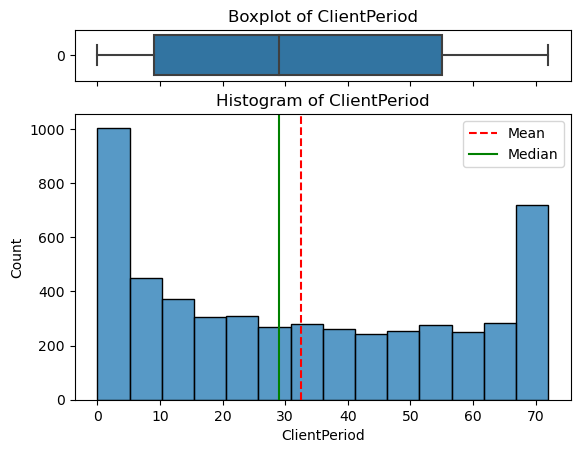

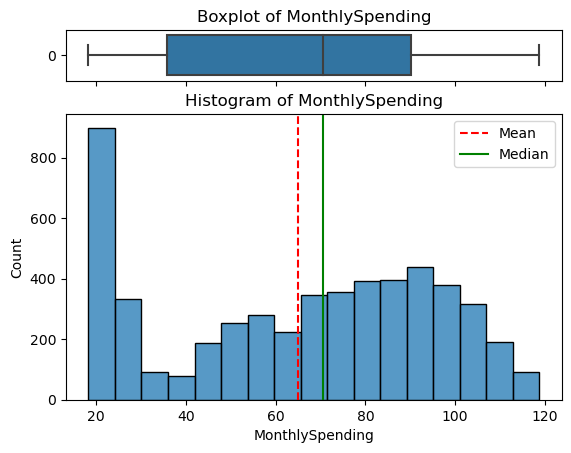

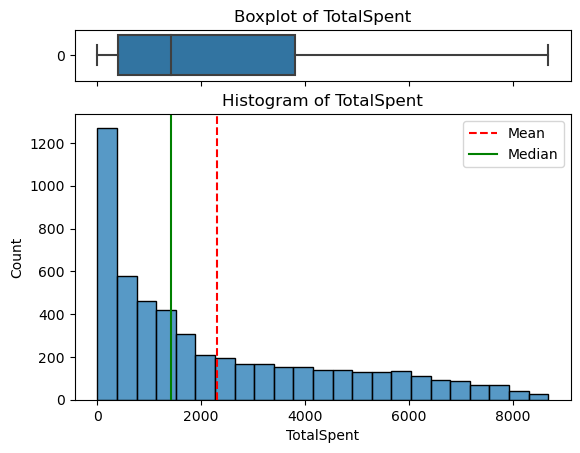

In [41]:
# построение графиков 
make_hist_box(train, num_cols)

- По `ClientPeriod` видно, что основные пики у людей, которые долго остаются абонентами и которые уходят сразу же.
- По  `MonthlySpenfing` видно, что в основном тратят в месяц минимальную цену - 20, но чаще среднее (и медиана) смещена к 65-70.
- По `TotalSpent` видно, что больше всего клиентов, которые чаще уходят (меньше итоговая сумма оплаты). 

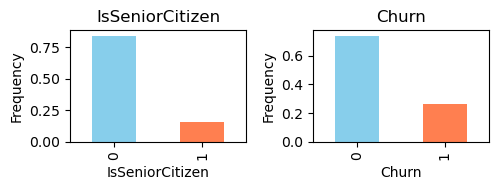

In [43]:
# График
plt.figure(figsize=(5, 2))

# График для 'IsSeniorCitizen'
plt.subplot(1, 2, 1)  # 1 строка, 2 столбца, 1-й график
violations_counts = train['IsSeniorCitizen'].value_counts(normalize=True)
violations_counts.plot(kind='bar', title='IsSeniorCitizen', color=['skyblue', 'coral'])  
plt.ylabel('Frequency')

# График для 'Churn'
plt.subplot(1, 2, 2)  # 1 строка, 2 столбца, 2-й график
violations_counts = train['Churn'].value_counts(normalize=True)
violations_counts.plot(kind='bar', title='Churn', color=['skyblue', 'coral']) 
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Преимущественно, абонентами являются не пенсионеры.
- Большениство клиентов не ушли. Однако процент ушедших - высок. Виден дисбаланс класса

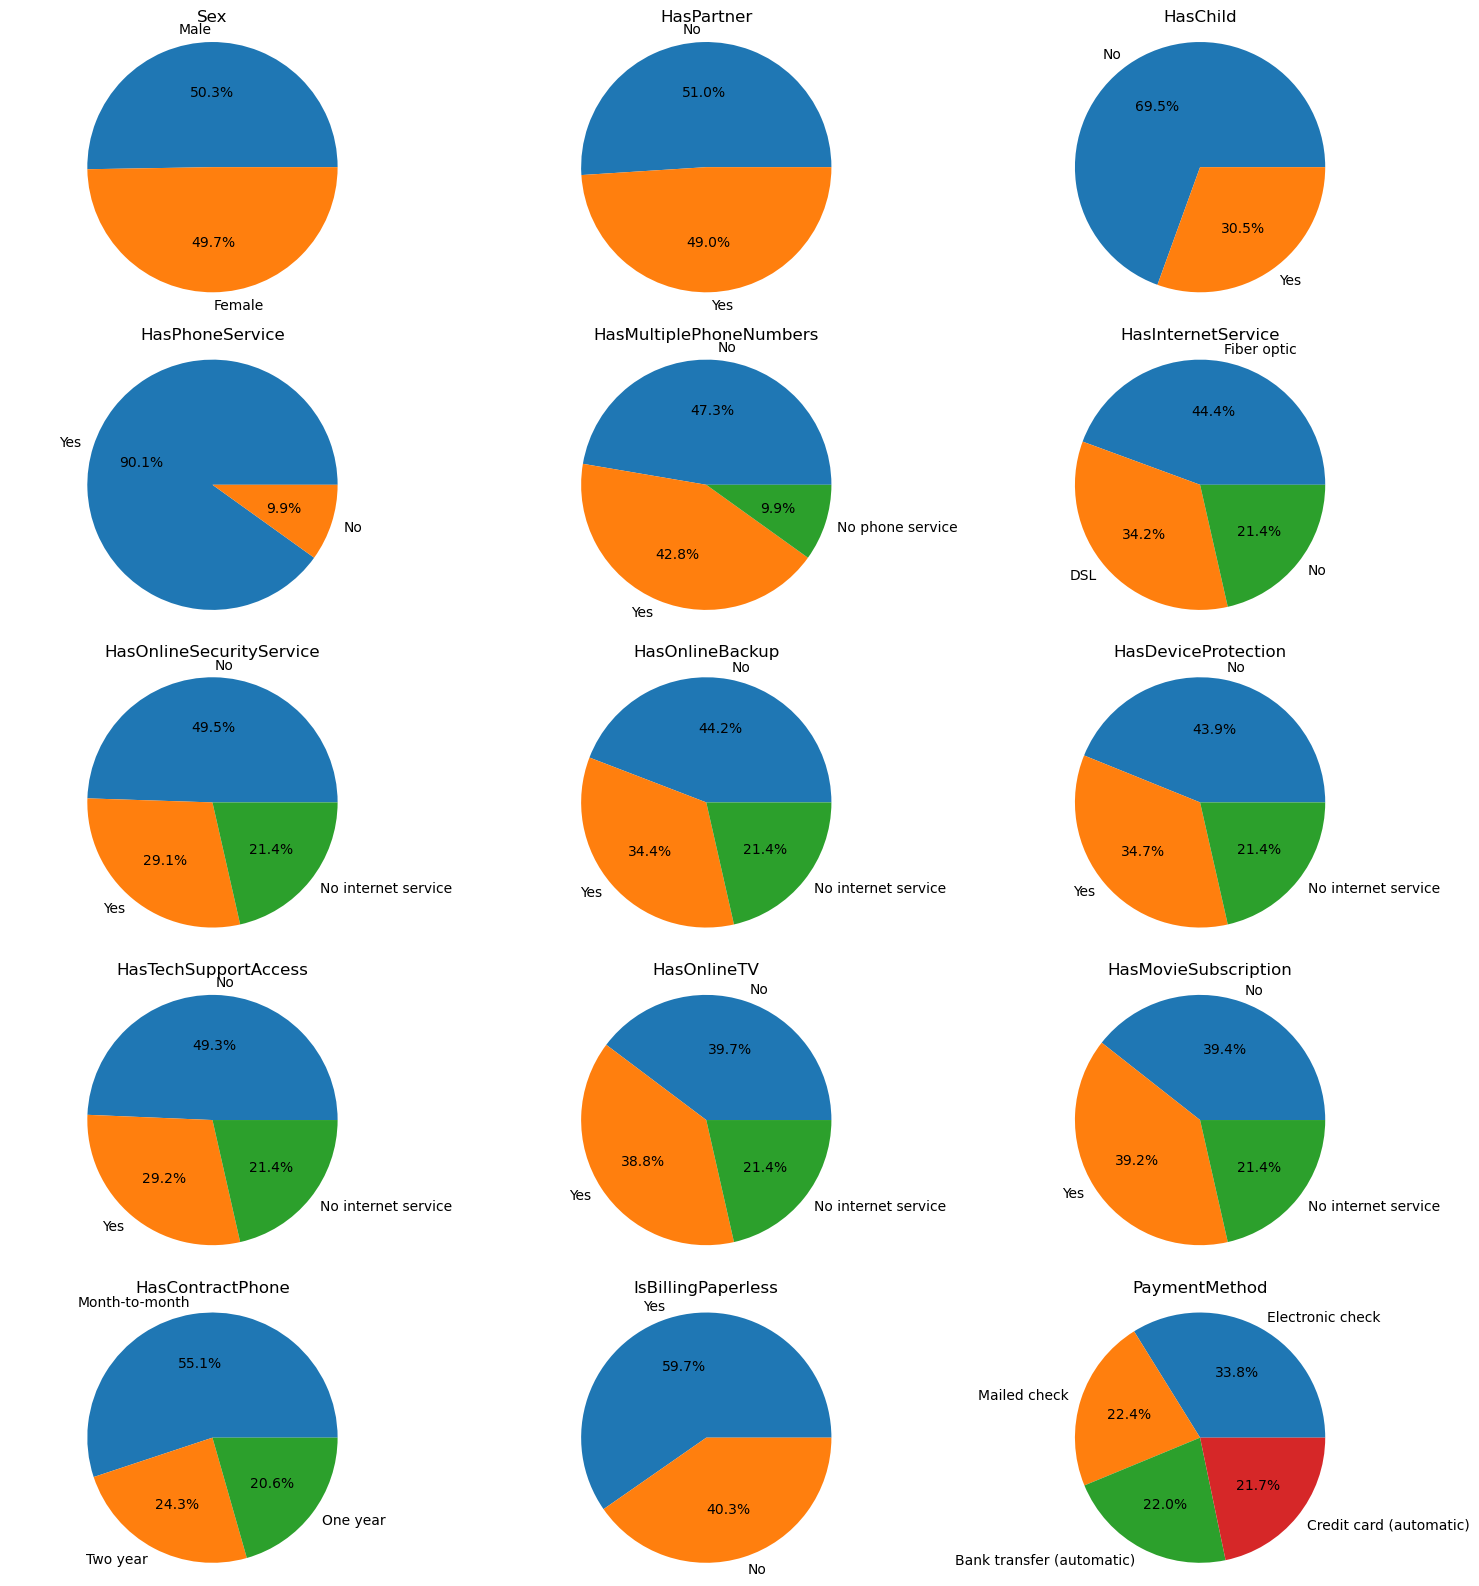

In [45]:
# построение графиков для категориальных признаков
ncols = 3
nrows = (len(cat_cols) + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 16))
axes = axes.ravel()

for i, feature in enumerate(cat_cols):
    ax = axes[i]
    feature_counts = train[feature].value_counts()
    ax.pie(feature_counts, labels=feature_counts.index, autopct='%1.1f%%')
    ax.set_title(feature)
    ax.axis("equal")

plt.subplots_adjust(wspace=0.6, hspace=1)
plt.tight_layout()
plt.show()

Распределение данных: 
- `Sex`, `HasPartner` - примерно равное количество,
- `HasChild` - преимущественно без детей, 
- `HasPhoneService` - чаще всего имеют эту услугу, 
- `HasMultiplePhoneNumbers`, `HasOnlineSecurityService`, `HasOnlineBackup`, `HasDeviceProtection`, `HasTechSupportAccess`, `HasOnlineTV`, `HasMovieSubscription` - чаще всего не имюет эту услугу, 
- `HasInternetService` - самое популярное Fiber Optic 
- `HasContractPhone`- чаще всего платят в Month-to-month 
- `IsBillingPaperless` - чаще всего электронный чек
- `PaymentMethod` - примерно равные части, но чаще всего электронный чек

### Портрет пользователя 

,Уникальные значения столбца Sex,Доля клиентов,Churn
0,Male,0.74,0
1,Female,0.74,0
2,Male,0.26,1
3,Female,0.26,1


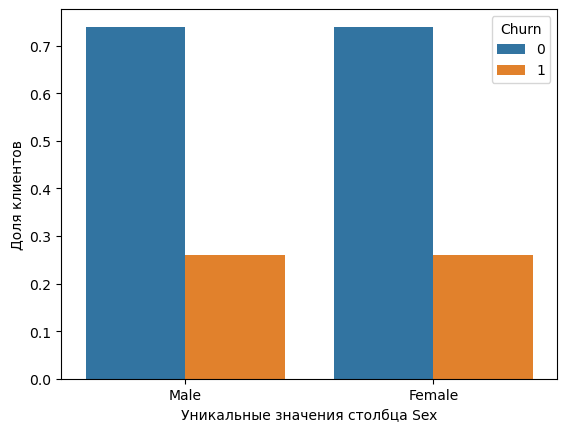


__________________________________________________



,Уникальные значения столбца HasPartner,Доля клиентов,Churn
0,Yes,0.80,0
1,No,0.68,0
2,Yes,0.20,1
3,No,0.32,1


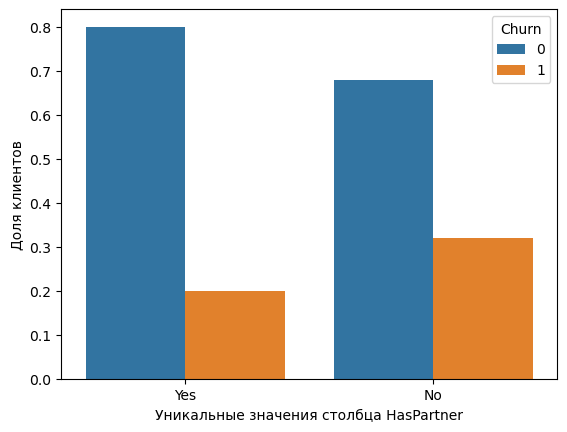


__________________________________________________



,Уникальные значения столбца HasChild,Доля клиентов,Churn
0,Yes,0.85,0
1,No,0.69,0
2,Yes,0.15,1
3,No,0.31,1


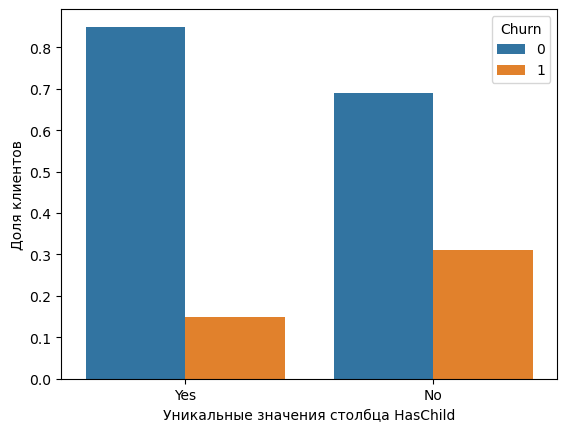


__________________________________________________



,Уникальные значения столбца HasPhoneService,Доля клиентов,Churn
0,Yes,0.74,0
1,No,0.75,0
2,Yes,0.26,1
3,No,0.25,1


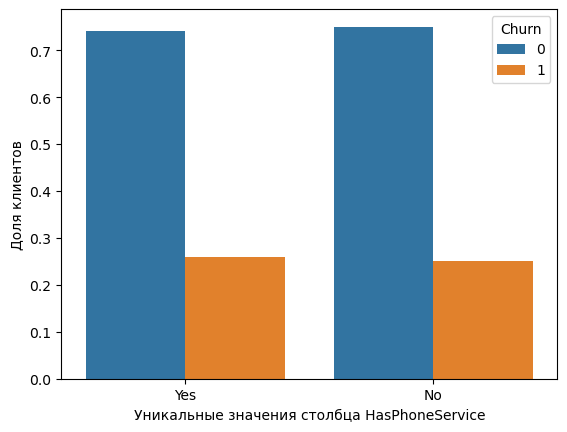


__________________________________________________



,Уникальные значения столбца HasMultiplePhoneNumbers,Доля клиентов,Churn
0,No,0.76,0
1,Yes,0.72,0
2,No phone service,0.75,0
3,No,0.24,1
4,Yes,0.28,1
5,No phone service,0.25,1


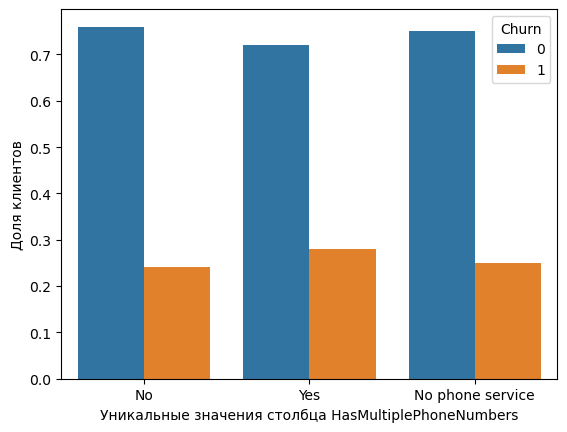


__________________________________________________



,Уникальные значения столбца HasInternetService,Доля клиентов,Churn
0,No,0.93,0
1,Fiber optic,0.59,0
2,DSL,0.81,0
3,No,0.07,1
4,Fiber optic,0.41,1
5,DSL,0.19,1


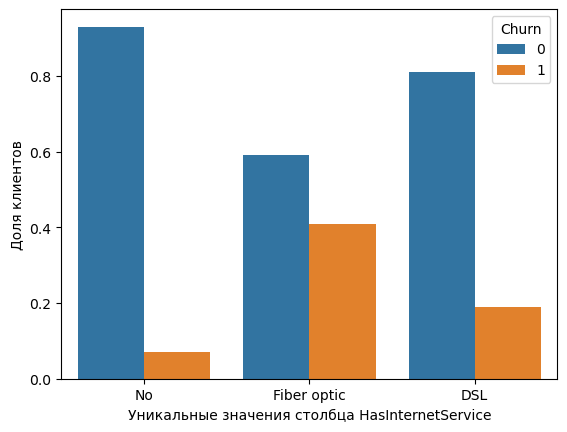


__________________________________________________



,Уникальные значения столбца HasOnlineSecurityService,Доля клиентов,Churn
0,No internet service,0.93,0
1,No,0.58,0
2,Yes,0.86,0
3,No internet service,0.07,1
4,No,0.42,1
5,Yes,0.14,1


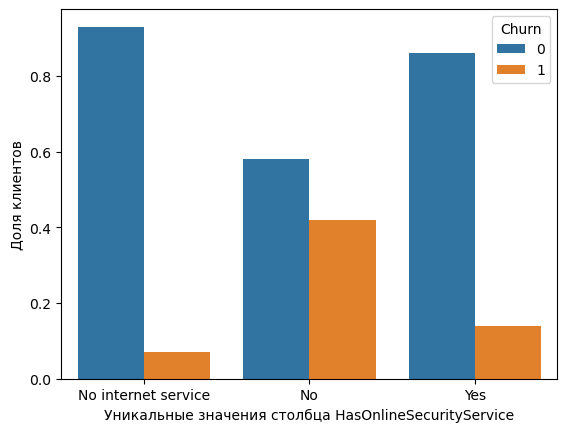


__________________________________________________



,Уникальные значения столбца HasOnlineBackup,Доля клиентов,Churn
0,No internet service,0.93,0
1,No,0.61,0
2,Yes,0.79,0
3,No internet service,0.07,1
4,No,0.39,1
5,Yes,0.21,1


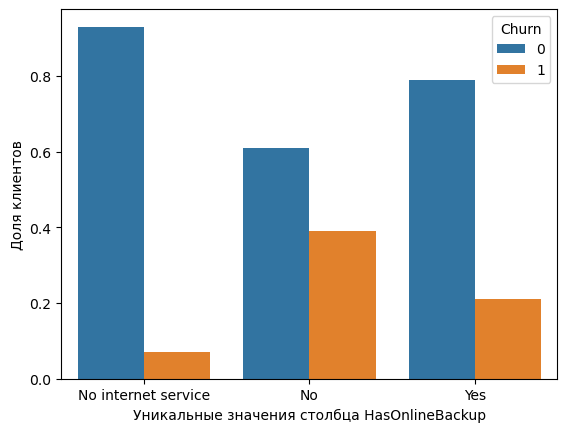


__________________________________________________



,Уникальные значения столбца HasDeviceProtection,Доля клиентов,Churn
0,No internet service,0.93,0
1,No,0.61,0
2,Yes,0.78,0
3,No internet service,0.07,1
4,No,0.39,1
5,Yes,0.22,1


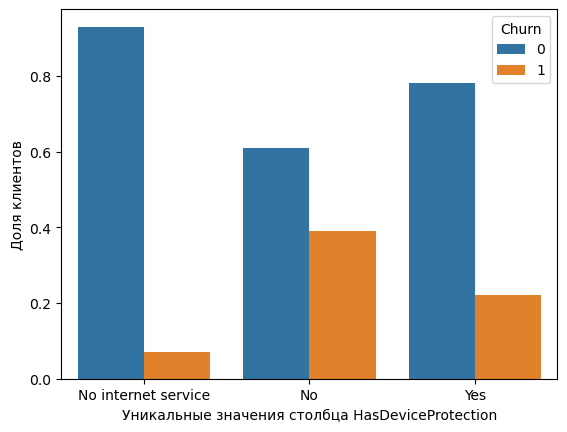


__________________________________________________



,Уникальные значения столбца HasTechSupportAccess,Доля клиентов,Churn
0,No internet service,0.93,0
1,Yes,0.85,0
2,No,0.59,0
3,No internet service,0.07,1
4,Yes,0.15,1
5,No,0.41,1


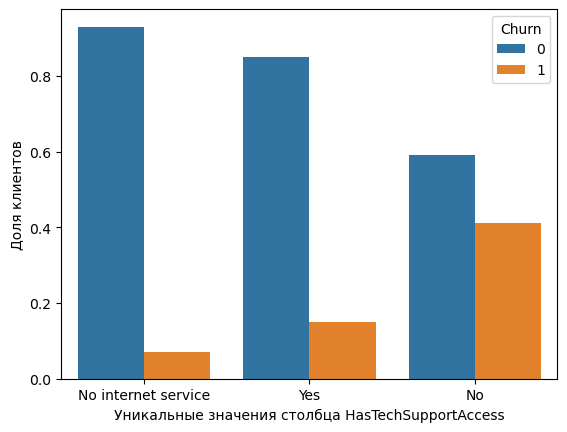


__________________________________________________



,Уникальные значения столбца HasOnlineTV,Доля клиентов,Churn
0,No internet service,0.93,0
1,No,0.67,0
2,Yes,0.71,0
3,No internet service,0.07,1
4,No,0.33,1
5,Yes,0.29,1


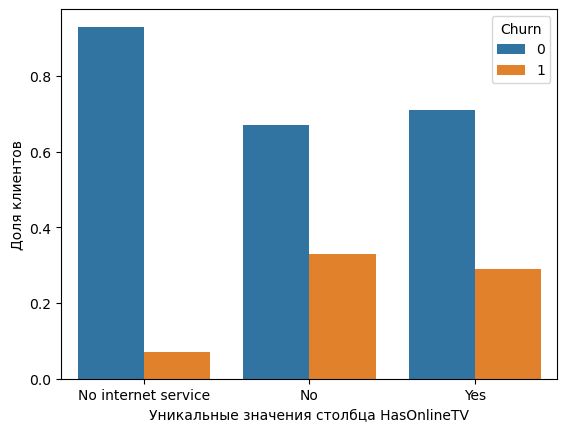


__________________________________________________



,Уникальные значения столбца HasMovieSubscription,Доля клиентов,Churn
0,No internet service,0.93,0
1,No,0.66,0
2,Yes,0.71,0
3,No internet service,0.07,1
4,No,0.34,1
5,Yes,0.29,1


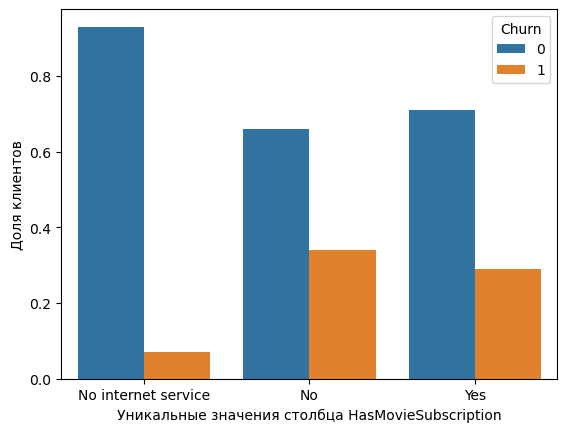


__________________________________________________



,Уникальные значения столбца HasContractPhone,Доля клиентов,Churn
0,One year,0.89,0
1,Two year,0.97,0
2,Month-to-month,0.58,0
3,One year,0.11,1
4,Two year,0.03,1
5,Month-to-month,0.42,1


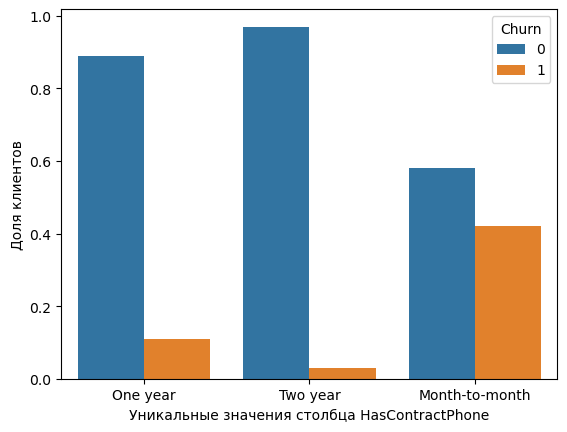


__________________________________________________



,Уникальные значения столбца IsBillingPaperless,Доля клиентов,Churn
0,No,0.84,0
1,Yes,0.67,0
2,No,0.16,1
3,Yes,0.33,1


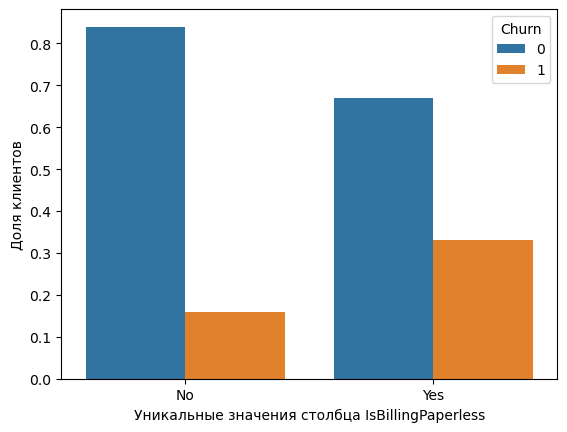


__________________________________________________



,Уникальные значения столбца PaymentMethod,Доля клиентов,Churn
0,Mailed check,0.81,0
1,Credit card (automatic),0.86,0
2,Electronic check,0.56,0
3,Bank transfer (automatic),0.83,0
4,Mailed check,0.19,1
5,Credit card (automatic),0.14,1
6,Electronic check,0.44,1
7,Bank transfer (automatic),0.17,1


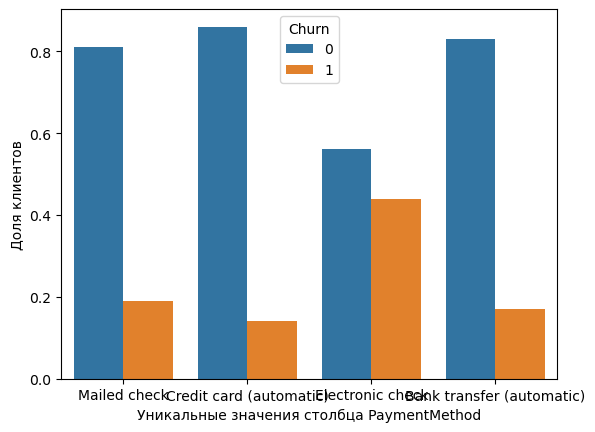


__________________________________________________



In [48]:
# изучим партрет ушедших клиентов 
for i in cat_cols:
    proba_plot(train, i)

Профиль ушедшего абонента: 
- `Sex` - примерно равное значение
- `HasPartner` - у кого нет супруга - уходят чаще
- `HasChild` -  без детей уходят в 2 раза чаще, чем с детьми
- `HasPhoneService` - примерно равное значение
- `HasMultiplePhoneNumbers` - без услуги чаще уходят
- `HasInternetService` - с Fiber optic уходят чаще
- `HasOnlineSecurityService`, `HasOnlineBackup`,`HasDeviceProtection`, `HasTechSupportAccess`,`HasOnlineTV`, `HasMovieSubscription`   - без услуги уходят чаще
- `HasContractPhone` - уходят чаще Month-to-month	
- `IsBillingPaperless` - с электронным расчетным листом чаще уходят
- `PaymentMethod`	 - уходит чаще Electronic check	

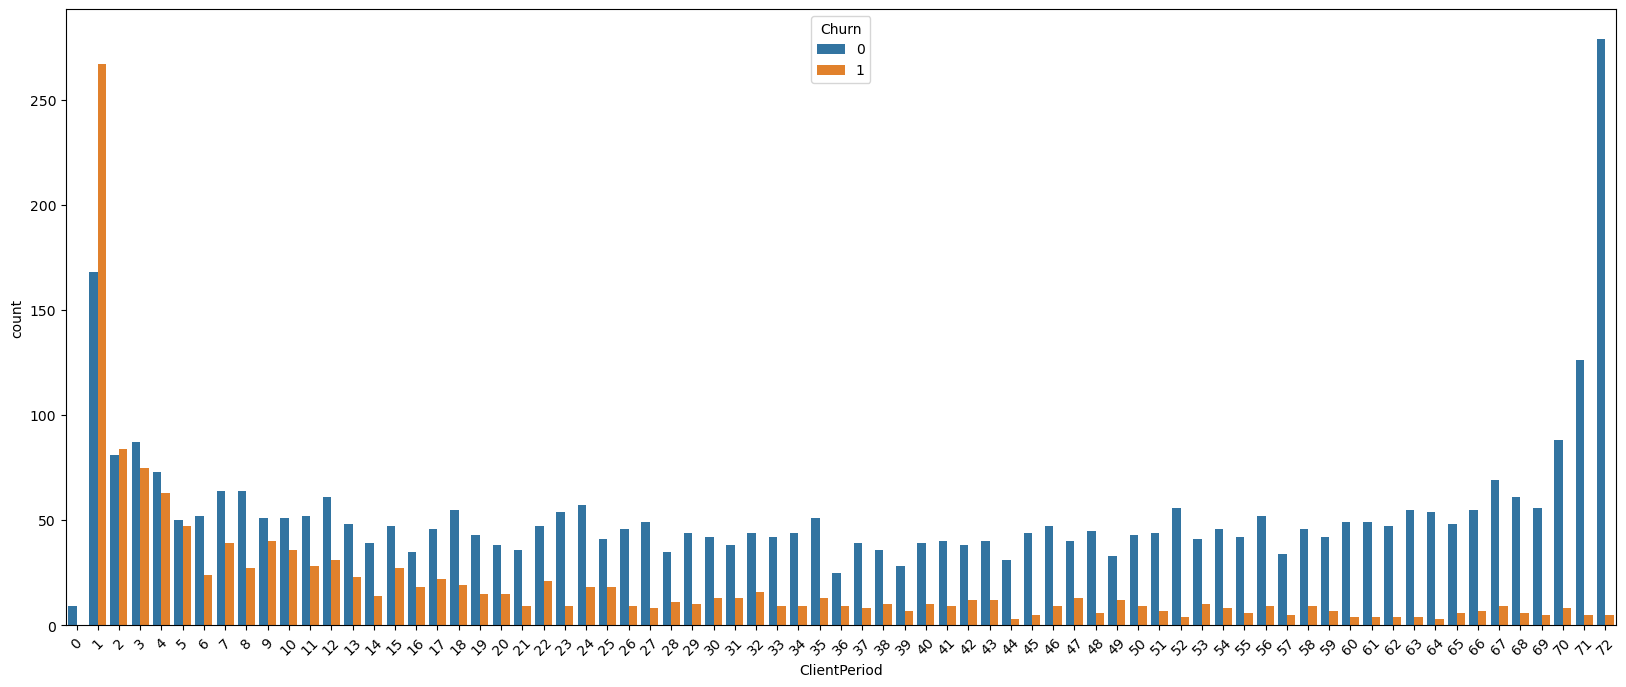

In [50]:
# связь между "ClientPeriod" и "Churn"
fig, ax = plt.subplots(figsize=(20, 8)) 
sns.countplot(data=train, x="ClientPeriod", hue="Churn", ax=ax)  
plt.xticks(rotation=45)
plt.show()

Видно, что чаще всего уходят абоненты в начале, чем дольше они используют услуги, тем реже уходят

## Корреляционный анализ

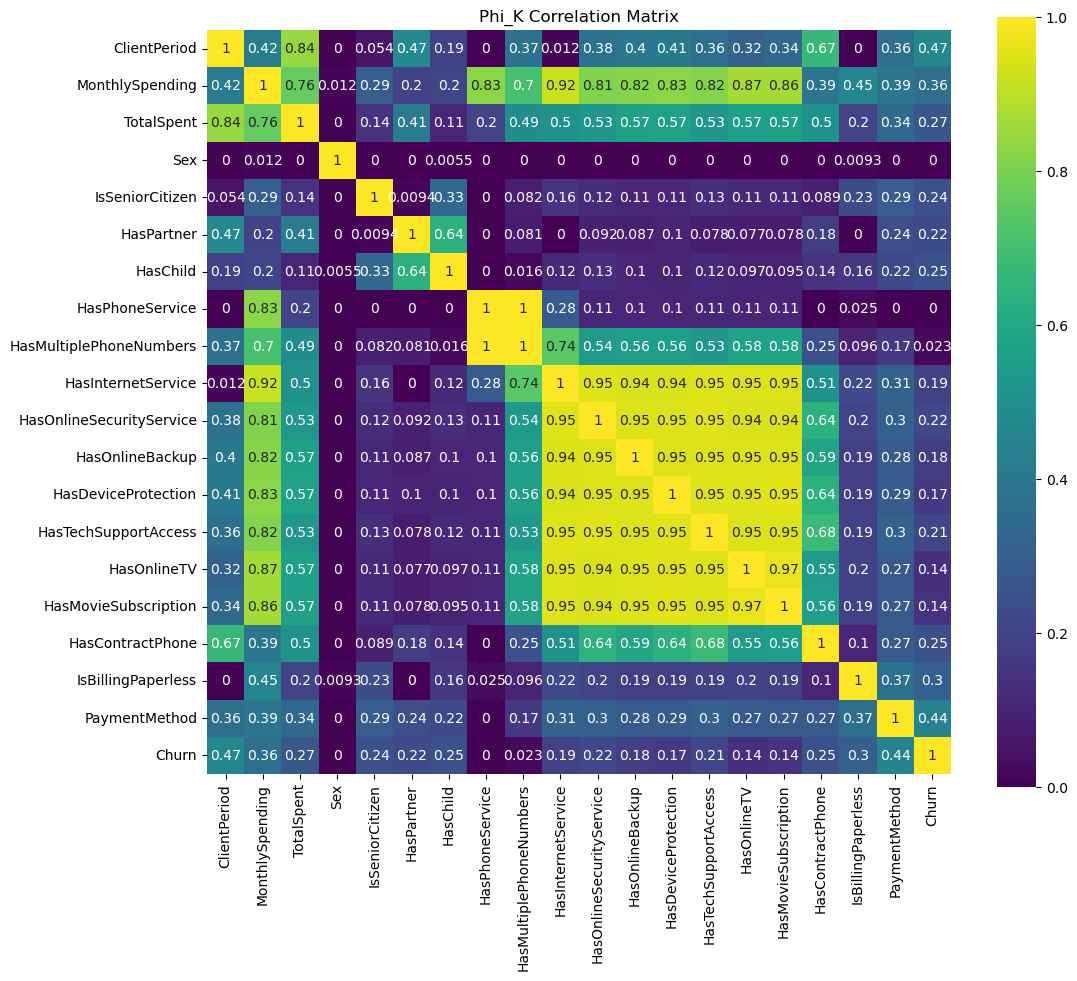

In [53]:
# Создание фигуры и осей с заданным размером
plt.figure(figsize=(12, 10))

# Построение тепловой карты
heatmap = sns.heatmap(train.phik_matrix(interval_cols=num_cols), annot=True, cmap='viridis', square=True)

# Добавление названия к тепловой карте
heatmap.set_title('Phi_K Correlation Matrix')

# Отображение тепловой карты
plt.show();

Как видно из матрицы корреляции, много признаков коррелируют между собой. Высокой корреляции (0.8-0.9 и выше) следует избегать. Можно перевести категориальные признаки в числовые типы данных int

In [55]:
categorical_features = [
    'Sex', 'HasPartner', 'HasChild', 'HasPhoneService', 
    'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 
    'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 
    'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 
    'IsBillingPaperless', 'PaymentMethod'
]

mapping = {
    'Sex': {'Male': 0, 'Female': 1},
    'HasPartner': {'No': 0, 'Yes': 1},
    'HasChild': {'No': 0, 'Yes': 1},
    'HasPhoneService': {'No': 0, 'Yes': 1},
    'HasMultiplePhoneNumbers': {'No': 0, 'No phone service': 0, 'Yes': 1},
    'HasInternetService': {'No': 0, 'DSL': 1, 'Fiber optic': 2},
    'HasOnlineSecurityService': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasOnlineBackup': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasDeviceProtection': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasTechSupportAccess': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasOnlineTV': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasMovieSubscription': {'No': 0, 'No internet service': 0, 'Yes': 1},
    'HasContractPhone': {'Month-to-month': 0, 'One year': 1, 'Two year': 2},
    'IsBillingPaperless': {'No': 0, 'Yes': 1},
    'PaymentMethod': {'Credit card (automatic)': 0,
                      'Bank transfer (automatic)': 1, 'Mailed check': 2, 'Electronic check': 3}
}

for feature in categorical_features:
    train[feature] = train[feature].replace(mapping[feature]).astype(int)

for feature in categorical_features:
    X_test[feature] = X_test[feature].replace(mapping[feature]).astype(int)

Так как изменили тип данных, то обновим num_cols

In [57]:
# создание num_cols
num_cols = train.select_dtypes(include='number').drop('Churn', axis=1).columns.tolist()

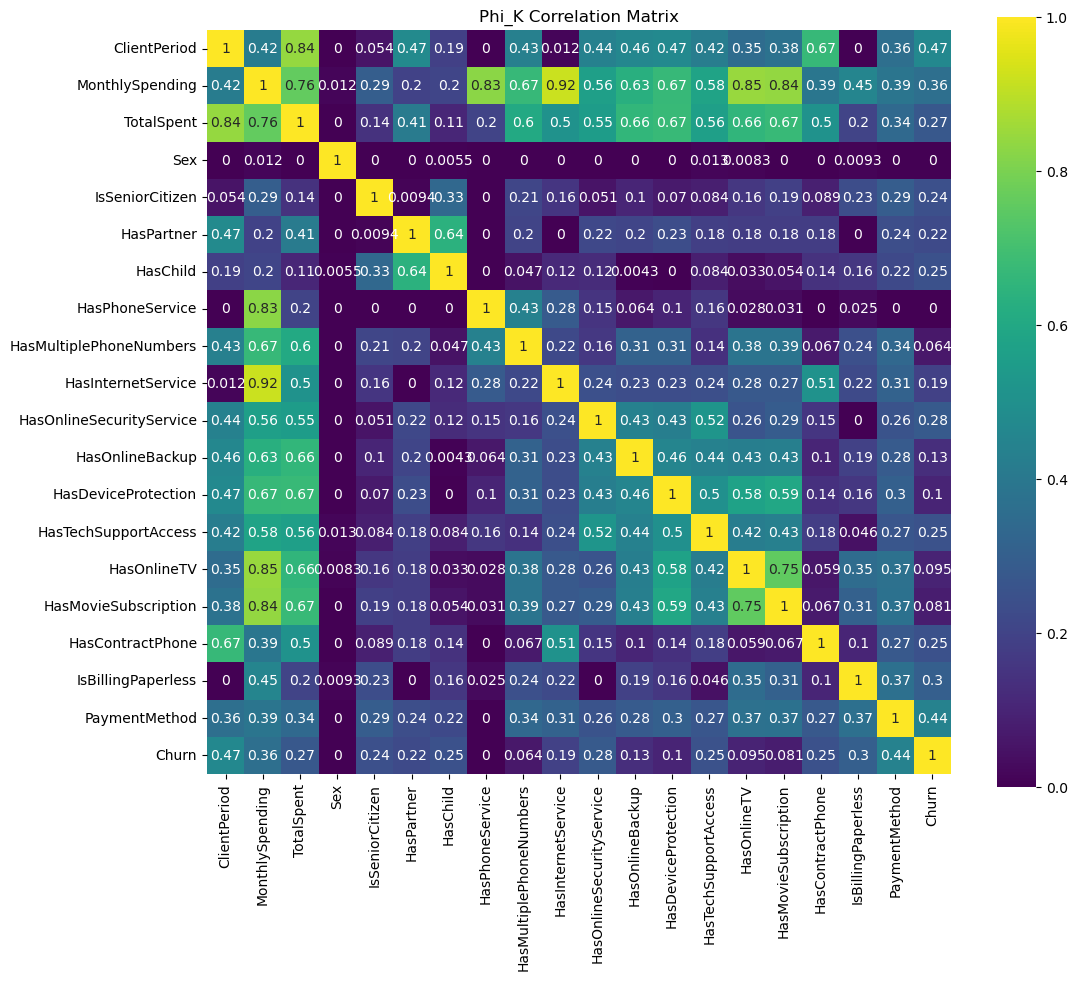

In [58]:
# Создание фигуры и осей с заданным размером
plt.figure(figsize=(12, 10))

# Построение тепловой карты
heatmap = sns.heatmap(train.phik_matrix(interval_cols=num_cols), annot=True, cmap='viridis', square=True)

# Добавление названия к тепловой карте
heatmap.set_title('Phi_K Correlation Matrix')

# Отображение тепловой карты
plt.show();

In [59]:
# Получение phi_k корреляционной матрицы
phi_k_matrix = train.phik_matrix(interval_cols=num_cols)

# Поиск столбцов с корреляцией выше 0.85
high_corr_cols = set()
for col1 in phi_k_matrix.columns:
    for col2 in phi_k_matrix.columns:
        if phi_k_matrix.loc[col1, col2] > 0.85 and col1 != col2:
            high_corr_cols.add(col1)
            high_corr_cols.add(col2)

# Вывод названий столбцов с высокой корреляцией
print("Столбцы с корреляцией выше 0.85:")
for col in high_corr_cols:
    print(f"- '{col}'")

Столбцы с корреляцией выше 0.85:
- 'MonthlySpending'
- 'HasInternetService'


- Сильно выраженные мультиколлинеарные признаки (выше 0.85) требуется исключить датафрейма при обучении моделей.

## Подготовка данных

In [62]:
# Удаление признаков в высокой мультиколлинеарностью 
train = train.drop(['HasInternetService', 'MonthlySpending'], axis=1)
X_test = X_test.drop(['HasInternetService', 'MonthlySpending'], axis=1)

In [63]:
# Назначение переменных фичей и целевого признака
X_train= train.drop(['Churn'], axis=1)
y_train = train['Churn']
print('Размер тренировочной выборки - {:.0%}'.format(X_train.shape[0]/(X_test.shape[0]+X_train.shape[0])))

Размер тренировочной выборки - 75%


In [64]:
# создайте списки с количественными и категориальными признаками
num_columns = X_train.select_dtypes(include=['float', 'int']).columns.tolist()
cat_columns = X_train.select_dtypes(include=['object', 'category']).columns.tolist()

In [65]:
print("Количество столбцов в X_train:", len(X_train.columns))
print("Количество категориальных столбцов для кодера:", len(cat_columns))
print("Количество числовых столбцов для масштабирования:", len(num_columns))

Количество столбцов в X_train: 17
Количество категориальных столбцов для кодера: 0
Количество числовых столбцов для масштабирования: 17


## Обучение модели

Используем 2 кодера, OneHotEncoder для LogisticRegression, и OrdinalEncoder для  DecisionTreeClassifier и CatBoostClassifier. Пропишем гиперпараметры, каждой модели

In [68]:
# словарь для модели LogisticRegression()
param_grid_lr = [{
        'models': [LogisticRegression(random_state=RANDOM_STATE, solver='liblinear',
                class_weight='balanced', penalty='l1')],
        'models__C': range(1, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }]

In [69]:
# время обучения и лучшая метрика модели LogisticRegression()
start_time_lr = time.time()
best_lr_model, best_lr_score, best_lr_params = pipe_learn_ohe(param_grid_lr)
print(f'Лучшая метрика roc-auc: {best_lr_score}')
finish_time_lr = time.time()
funtion_time_lr = round(finish_time_lr - start_time_lr,4)
print(f'Время обучения: {funtion_time_lr} секунд')

Лучшая метрика roc-auc: 0.8346596192529567
Время обучения: 3.53 секунд


In [70]:
# словарь для модели DecisionTreeClassifier()
param_grid_DTC = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__max_features': range(2, 15),
        'models__min_samples_split': range(2, 15),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']}]

In [71]:
# время обучения и лучшая метрика модели DecisionTreeClassifier()
start_time_DTC = time.time()
best_DTC_model, best_DTC_score, best_DTC_params = pipe_learn_ord(param_grid_DTC)
print(f'Лучшая метрика roc-auc: {best_DTC_score}')
finish_time_DTC = time.time()
funtion_time_DTC = round(finish_time_DTC - start_time_DTC,4)
print(f'Время обучения: {funtion_time_DTC} секунд')

Лучшая метрика roc-auc: 0.7982847968612664
Время обучения: 0.4198 секунд


In [72]:
 # словарь для модели CatBoostClassifier()
param_grid_cat = [
        {
        'models': [CatBoostClassifier(random_state=RANDOM_STATE, verbose=False)],
        'models__max_depth': range(2, 6),
        'models__iterations': [20, 50, 100],
        'models__learning_rate': [0.3, 1],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']   
        }]

In [73]:
# время обучения и лучшая метрика модели CatBoostClassifier()
start_time_сat = time.time()
best_сat_model, best_сat_score, best_сat_params = pipe_learn_ord(param_grid_cat)
print(f'Лучшая метрика roc-auc: {best_сat_score}')
finish_time_сat = time.time()
funtion_time_сat = round(finish_time_сat - start_time_сat,4)
print(f'Время обучения: {funtion_time_сat} секунд')

Лучшая метрика roc-auc: 0.8423488253882686
Время обучения: 8.0047 секунд


### Выбор модели

In [75]:
# создание сводной таблицы 
results = {
    'Название модели': ['Logistic Regression', 'Decision Tree Classifier', 'CatBoost Classifier'],
    'Время обучения': [funtion_time_lr, funtion_time_DTC, funtion_time_сat],
    'Лучшая метрика': [best_lr_score, best_DTC_score, best_сat_score]
}

# Создание DataFrame
results = pd.DataFrame(results)
print (results)

            Название модели  Время обучения  Лучшая метрика
0       Logistic Regression          3.5300        0.834660
1  Decision Tree Classifier          0.4198        0.798285
2       CatBoost Classifier          8.0047        0.842349


In [76]:
print(f'Параметры лучшей модели {best_сat_params}')

Параметры лучшей модели {'preprocessor__num': RobustScaler(), 'models__max_depth': 2, 'models__learning_rate': 0.3, 'models__iterations': 100, 'models': <catboost.core.CatBoostClassifier object at 0x00000221C468DF10>}


In [77]:
# подготовим дф для предсказания
submission = X_test.copy()

# Предсказание 
start_time = time.time()

# проверьте работу модели на тестовой выборке
submission['Churn'] = best_сat_model.predict_proba(X_test)[:, 1]

finish_time = time.time()
funtion_time = round(finish_time - start_time,4)
print(f'Время предсказания: {funtion_time} секунд')

Время предсказания: 0.005 секунд


In [78]:
#Сохранение результатов предсказания и оформление в нужный формат  
submission = submission['Churn'].reset_index().rename(columns={'index': 'id'})
#просмотр результата 
submission.tail()

,id,Churn
1756,1756,0.109784
1757,1757,0.010865
1758,1758,0.840213
1759,1759,0.563326
1760,1760,0.013581


In [79]:
# сохранение файла 
submission.to_csv("./" + "./dp_submission.csv", index=False)

## Анализ важности признаков

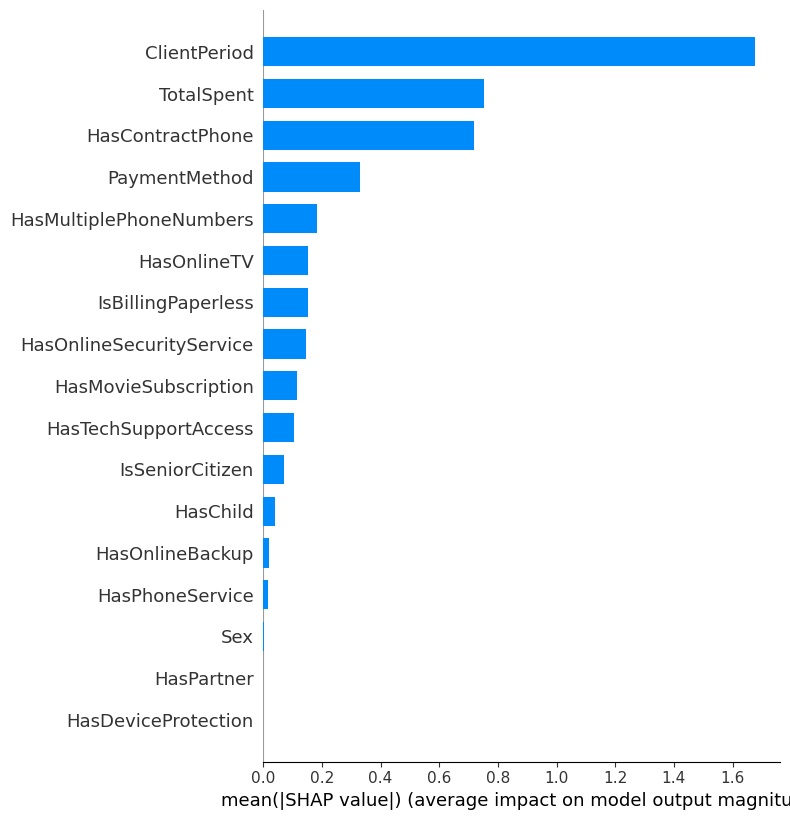

In [81]:
# Получите доступ к обученной модели CatBoost из пайплайна
catboost_model = best_сat_model.named_steps['models']

# Создайте обертку для модели CatBoost
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_test)

# Постройте график SHAP значений
shap.summary_plot(shap_values, X_test, plot_type="bar")

- Наиболее значимым признаком является:
`ClientPeriod`>`TotalSpent`>`HasContractPhone`>`PaymentMethod`>`HasMultiplePhoneNumbers`>
`HasOnlineTV`>`IsBillingPaperless`>`HasOnlineSecurityService`>`HasTechSupportAccess`>
`IsSeniorCitizen`>`HasChild`>`HasOnlineBackup`>`HasPhoneService`>`Sex`>`HasPartner`>`HasDeviceProtection`

## Выводы
- 1. Предобработка данных:
    - загрузка датасетов,
    - поиск дубликатов, пропускаов и пробелов вместо пропусков,
    - пропуски-пробелы `TotalSpent` были заменены на "0", так как это новые пользователи 
    - признаки переведены в корректный тип данных.
- 2. Исследовательский аналз данных
     - Было описано распределение каждого признака
     - Был создан профиль ушедшего клиента
        - Чаще всего уходят абоненты в начале, чем дольше они используют услуги, тем реже уходят
        - Чаще всего уходят абоненты без супруга, без детей. 
        - Также у которых нет доп услуг, которые используют `Fiber optic`, которые платят `Month-to-month` 
- 3. Корреляционный анализ:
     - обнаружена высокая корреляция у `HasInternetService`, `MonthlySpending`
- 4. Подготовка к обучению:
     - Удалены признаки, которые имеют высокое значение мультколлинеарности
     - Тренировочная выборка разделена на датасет только с таргетом и только с признаками
     -  В качестве моделей были выбраны: `LogisticRegression`, `DecisionTreeClassifier`, `CatBoostClassifier`
     -  К каждой модели были выбраны различные гиперпараметры для получения наилучшей модели.
     -  Было исопльзование 2 метода кодирования. `neHotEncoder` для `LogisticRegression`, и `OrdinalEncoder` для `DecisionTreeClassifier` и `CatBoostClassifier`
     -  У лучшей модели на кросс-валидации `roc_auc` получилась равной 0.842. Параметры данной модели:
   - RobustScaler(),
   - 'models__max_depth': 2,
   - 'models__learning_rate': 0.3,
   - 'models__iterations': 100
- 5. Анализ важности признаков:
    - `ClientPeriod`>`TotalSpent`>`HasContractPhone`>`PaymentMethod`>`HasMultiplePhoneNumbers`>`HasOnlineTV`>
    - `IsBillingPaperless`>`HasOnlineSecurityService`>`HasTechSupportAccess`>`IsSeniorCitizen`>`HasChild`>
    - `HasOnlineBackup`>`HasPhoneService`>`Sex`>`HasPartner`>`HasDeviceProtection`